In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate, scipy.signal
from functions import *

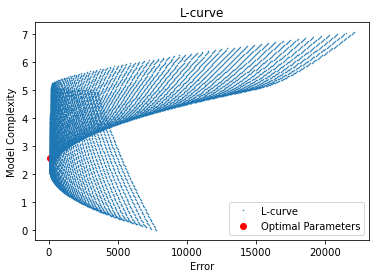

Optimal Parameters:
Parameter 1: 1.8686868686868687
Parameter 2: 1.7676767676767677


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define your model function
def model_function(x, params):
    # Example model function (you should replace this with your actual model)
    return params[0] * x + params[1]

# Generate some example data
np.random.seed(0)
x_data = np.linspace(0, 10, 50)
y_data = 2 * x_data + 1 + np.random.normal(0, 1, 50)

# Define a range of parameter values
param_range = np.linspace(0, 5, 100)

# Calculate the error metric for each parameter combination
errors = []
for param1 in param_range:
    for param2 in param_range:
        params = [param1, param2]
        y_pred = model_function(x_data, params)
        error = np.sum((y_data - y_pred) ** 2)  # Example error metric (sum of squared residuals)
        errors.append((param1, param2, error))

# Extract parameter values and errors
param1_values = np.array([entry[0] for entry in errors])
param2_values = np.array([entry[1] for entry in errors])
error_values = np.array([entry[2] for entry in errors])

# Plot the L-curve
plt.figure()
plt.plot(error_values, np.sqrt(param1_values**2 + param2_values**2),'.',markersize=1, label='L-curve')
plt.xlabel('Error')
plt.ylabel('Model Complexity')
plt.title('L-curve')
plt.legend()

# Find the corner of the L-curve
corner_index = np.argmin(error_values + np.sqrt(param1_values**2 + param2_values**2))
optimal_param1 = param1_values[corner_index]
optimal_param2 = param2_values[corner_index]

# Plot the optimal parameter
plt.scatter(error_values[corner_index], np.sqrt(optimal_param1**2 + optimal_param2**2),color='red', label='Optimal Parameters')
plt.legend()

plt.show()

print("Optimal Parameters:")
print("Parameter 1:", optimal_param1)
print("Parameter 2:", optimal_param2)

In [3]:
def force(param, T):
    return (np.ones(T)*param).reshape((1,T))

(1, 1000)


c:\Users\Karol\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


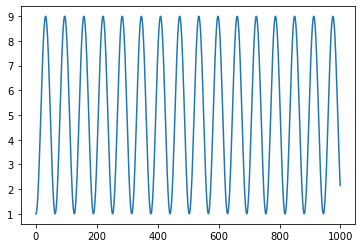

In [4]:
beta = 1/4
gamma = 1/2
deltaT = 0.1
T = 1000

m = 1
k = 1

M_new = 1/(beta*deltaT**2)*m+k

a = [1]
a_dot = [0]
a_ddot = [-k/m*a[0]]
f = force(5, T)
print(np.shape(f))

for i in range(T-1):
  F_new = m*(1/(beta*deltaT**2)*a[i]+1/(beta*deltaT)*a_dot[i]+1/(2*beta)*a_ddot[i]-a_ddot[i])+f[:,i+1]
  a_new = F_new/M_new
  a.append(a_new)
  a_ddot_new = 1/(beta*deltaT**2)*(a_new-a[i])-1/(beta*deltaT)*a_dot[i]-1/(2*beta)*a_ddot[i]+a_ddot[i]
  a_ddot.append(a_ddot_new)
  a_dot_new = a_dot[i]+deltaT*(1-gamma)*a_ddot[i]+deltaT*gamma*a_ddot_new
  a_dot.append(a_dot_new)

plt.plot(a)

In [5]:
M_new = 1/(beta*deltaT*deltaT)*m+k
M_hat = m/M_new

A11 = 1/(beta*deltaT**2)*M_hat
A12 = 1/(beta*deltaT)*M_hat
A13 = (1/(2*beta)-1)*M_hat
A21 = gamma/(beta*deltaT)*(1/(beta*deltaT**2)*M_hat-1)
A22 = gamma/beta*(1/(beta*deltaT**2)*M_hat-(1-beta/gamma)*1)
A23 = deltaT*gamma*(1/(2*beta)-1)*(1/(beta*deltaT**2)*M_hat-(1-(1-gamma)/(gamma*(1/(2*beta)-1)))*1)
A31 = 1/(beta*deltaT**2)*(1/(beta*deltaT**2)*M_hat-1)
A32 = 1/(beta*deltaT)*(1/(beta*deltaT**2)*M_hat-1)
A33 = (1/(2*beta)-1)*(1/(beta*deltaT**2)*M_hat-1)

A1 = np.hstack((A11, A12, A13))
A2 = np.hstack((A21, A22, A23))
A3 = np.hstack((A31, A32, A33))

A = np.vstack((A1, A2, A3))

In [6]:
M_new = 1/(beta*deltaT*deltaT)*m+k

B1 = 1/M_new
B2 = gamma/(beta*deltaT)/M_new
B3 = gamma/(beta*deltaT**2)/M_new

B = np.vstack((B1, B2, B3))

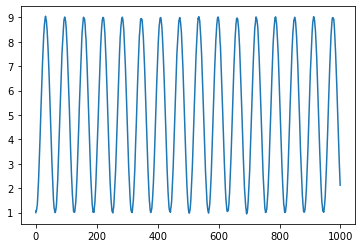

In [7]:
y = []
for i in range(len(a)):
    y.append(a[i] + np.random.normal(0, 0.01*np.std(a)))
plt.plot(y)

In [18]:
H = observe_displacements(A)

In [9]:
def Kalman_filter(A, B, H, x, f, y, sigma_0, sigma_r, sigma_q, T):
  Q = sigma_q*np.identity(np.shape(A)[0])
  R = sigma_r
  
  P = [sigma_0*np.identity(np.shape(A)[0])]

  energy = 0

  for i in range(T-1):
    x_predict = np.dot(A, x[:,i]) + np.dot(B, f[:,i+1])
    P_predict = np.dot(A, np.dot(P[i], np.transpose(A))) + Q
    V = y[i] - np.dot(H, x_predict)
    S = np.dot(H, np.dot(P_predict, np.transpose(H))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(S, np.transpose(K)))

    x = np.append(x, x_estimate.reshape(np.shape(A)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*V.T @ np.linalg.inv(S) @ V

  return x, energy

0.0


c:\Users\Karol\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


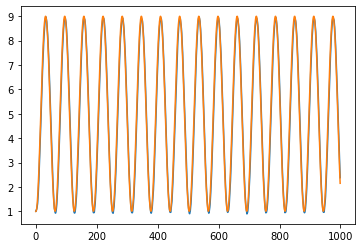

In [21]:
x = np.zeros((3,1))
x[0,0] = 1
# f = force(1, T)
x, energy = Kalman_filter(A, B, H, x, f, y, 1, 1, 1, T)
plt.plot(x[0,:])
plt.plot(a)
print(np.exp(-energy))

In [115]:
def Metropolis_Hastings(A, B, H, x, force_func, y, sigma_0, sigma_r, sigma_q, prior_mean, prior_var, beta, T, N, method):
  x_init = x
  X = []
  acc = 0

  param = []
  param.append(np.random.normal(prior_mean, prior_var))

  energy_list = []

  f = force_func(param[0], T)
  phi = 0.5*np.log(2*np.pi*prior_var)+1/(2*prior_var**2)*(param[0]-prior_mean)**2
  x, energy = Kalman_filter(A, B, H, x_init, f, y, sigma_0, sigma_r, sigma_q, T)
  X.append(x)
  phi += energy
  energy_list.append(phi)
  for j in tqdm(range(1,N)):
    if method == 'pcn':
      proposal = np.sqrt(1-beta**2)*param[j-1] + beta*np.random.normal(0, prior_var)
      phi = 0
    elif method == 'grw':
      proposal = param[j-1] + beta*np.random.normal(0, prior_var)
      phi = 0.5*np.log(2*np.pi*prior_var)+1/(2*prior_var**2)*(proposal-prior_mean)**2
    f = force_func(proposal, T)
    x, energy = Kalman_filter(A, B, H, x_init, f, y, sigma_0, sigma_r, sigma_q, T)
    X.append(x)
    phi += energy

    acceptance = min(0, (energy_list[j-1]-phi))
    uniform = np.random.uniform(0,1)
    if np.log(uniform) <= acceptance:
      acc += 1
      param.append(proposal)
      energy_list.append(phi)
    else:
      param.append(param[j-1])
      energy_list.append(energy_list[j-1])
  return param, energy_list, X, acc/N


In [41]:
def Metropolis_Hastings(A, B, H, x, force_func, y, sigma_0, sigma_r, sigma_q, prior_mean, prior_var, beta, T, N):
  x_init = x
  X = []

  param = []
  param.append(np.random.normal(prior_mean, prior_var))
  posterior = []

  f = force_func(param[0], T)
  phi = -0.5*np.log(2*np.pi*prior_var)-1/(2*prior_var**2)*(param[0]-prior_mean)
  x, energy = Kalman_filter(A, B, H, x_init, f, y, sigma_0, sigma_r, sigma_q, T)
  X.append(x)
  posterior.append(phi)
  for j in range(1,N):
    proposal = np.sqrt(1-beta**2)*param[j-1] + beta*np.random.normal(0, prior_var)
    f = force_func(param[j-1], T)
    log_prior = -0.5*np.log(2*np.pi*prior_var)-1/(2*prior_var**2)*(proposal-prior_mean)
    x, energy = Kalman_filter(A, B, H, x_init, f, y, sigma_0, sigma_r, sigma_q, T)
    var = 0.2*np.std(x[0,:])
    log_likelihood = (-0.5*np.log(2*np.pi*var)-1/(2*var**2)*(y-x[0,:])).sum()
    X.append(x)
    log_posterior = log_likelihood

    acceptance = (min(0, (posterior[j-1]-log_posterior)))
    uniform = np.random.uniform(0,1)
    if np.log(uniform) <= acceptance:
      param.append(proposal)
      posterior.append(log_posterior)
    else:
      param.append(param[j-1])
      posterior.append(posterior[j-1])
  return param, posterior, X

100%|██████████| 99/99 [00:11<00:00,  8.98it/s]

5.5594642633361016
0.13


Text(0, 0.5, 'Parameter Posterior')

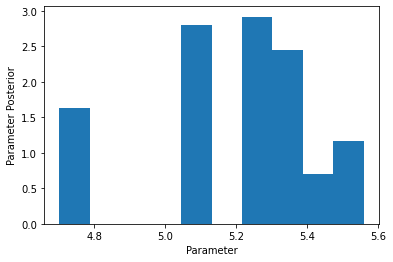

In [130]:
x = np.zeros((3,1))
x[0,0] = 1
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, force, y, 1, 0.01*np.std(a), 0.1, 4, 0.6, 0.3, T, 100, 'pcn')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

5.5594642633361016


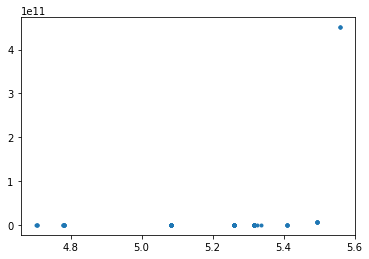

In [131]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

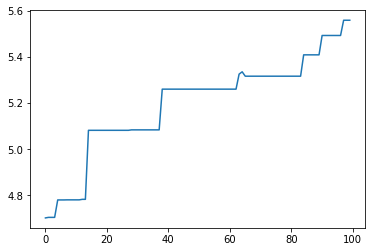

In [132]:
plt.plot(param)

In [42]:
def Kalman_filter_aug(A, B, H, x, force_func, y, sigma_0, sigma_r, sigma_q, sigma_epsilon, T):
  Q = sigma_q*np.identity(np.shape(A)[0])
  R = sigma_r
  
  P = [sigma_0*np.identity(np.shape(A)[0])]

  energy = 0

  for i in range(T-1):
    x_predict = np.dot(A, x[:,i]) + np.dot(B, f[:,i+1])
    P_predict = np.dot(A, np.dot(P[i], np.transpose(A))) + Q
    V = y[i] - np.dot(H, x_predict)
    S = np.dot(H, np.dot(P_predict, np.transpose(H))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(S, np.transpose(K)))
    x_estimate[-1] += np.random.normal(0,sigma_epsilon)

    x = np.append(x, x_estimate.reshape(np.shape(A)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, energy

In [43]:
param = [4]
x = np.zeros((3,1))
x[0,0] = 1
A_aug, B_aug, H_aug = aug_lin_model(A, B, H, x, param)

In [47]:
aug_state = np.vstack((x,param))
aug_state, energy = Kalman_filter_aug(A_aug, B_aug, H_aug, aug_state, force, y, 1, 0.1, 0.000001, 0.01, T)

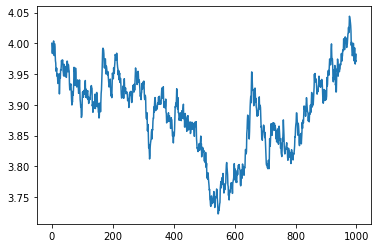

In [48]:
plt.plot(aug_state[-1,:])

In [2]:
def Metropolis_Hastings_test(x, y, noise_var, prior_mean, prior_var, beta, N, method):
  acc = 0
  M = len(x)

  param = []
  param.append(np.random.normal(prior_mean, prior_var))

  energy_list = []

  phi = 0.5*np.log(2*np.pi*prior_var)+1/(2*prior_var**2)*(param[0]-prior_mean)**2
  energy = 0.5*M*np.log(2*np.pi*noise_var)+0.5/noise_var*((y-x*param[0])**2).sum()
  phi += energy
  energy_list.append(phi)
  for j in tqdm(range(1,N)):
    if method == 'pcn':
      proposal = np.sqrt(1-beta**2)*param[j-1] + beta*np.random.normal(0, prior_var)
      phi = 0
    elif method == 'grw':
      proposal = param[j-1] + beta*np.random.normal(0, prior_var)
      phi = 0.5*np.log(2*np.pi*prior_var)+1/(2*prior_var**2)*(proposal-prior_mean)**2
    energy = 0.5*M*np.log(2*np.pi*noise_var)+0.5/noise_var*((y-x*proposal)**2).sum()
    phi += energy

    acceptance = min(0, (energy_list[j-1]-phi))
    uniform = np.random.uniform(0,1)
    if np.log(uniform) <= acceptance:
      acc += 1
      param.append(proposal)
      energy_list.append(phi)
    else:
      param.append(param[j-1])
      energy_list.append(energy_list[j-1])
  return param, energy_list, acc/N

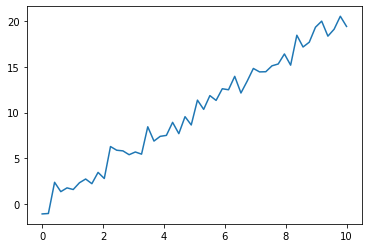

In [3]:
x = np.linspace(0,10,50)
y = []
for i in range(len(x)):
    y.append(2*x[i] + np.random.normal(0, 1))
plt.plot(x, y)

100%|██████████| 99/99 [00:00<00:00, 24669.44it/s]

2.020113367218029
0.19


Text(0, 0.5, 'Parameter Posterior')

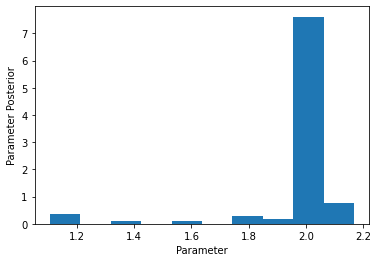

In [4]:
param, energy_list, acc = Metropolis_Hastings_test(x, y, 1, 0, 1, 0.2, 100, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

2.020113367218029


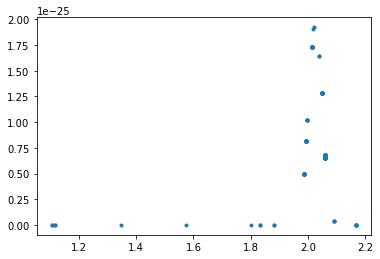

In [5]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale/10))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

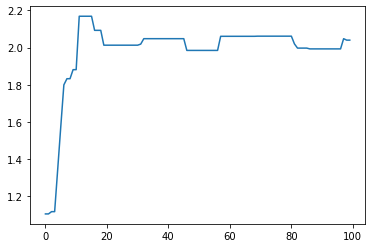

In [6]:
plt.plot(param)

100%|██████████| 99/99 [00:00<00:00, 31806.67it/s]

1.950788054166227
0.19


Text(0, 0.5, 'Parameter Posterior')

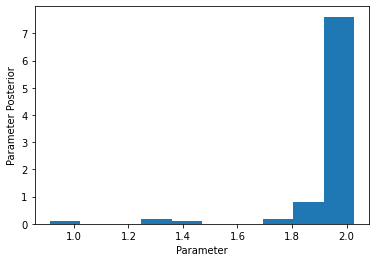

In [103]:
param, energy_list, acc = Metropolis_Hastings_test(x, y, 1, 0, 1, 0.2, 100, 'pcn')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

1.950788054166227


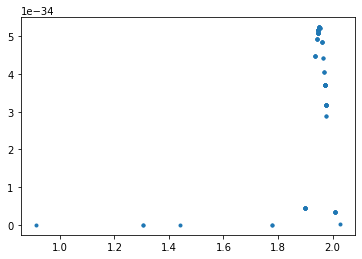

In [104]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale/20))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

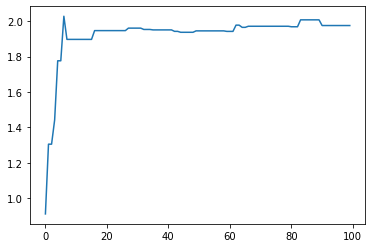

In [105]:
plt.plot(param)